# **Final Project**


## **Project Information**

### **Problem**
#### We want to predict the price of Ethereum based off of its previous prices.


### **Dataset**
#### The dataset we will be using is title "Cryptocurrency  extra data - Ethereum" and can be found at the following link: https://www.kaggle.com/yamqwe/cryptocurrency-extra-data-ethereum

#### The dataset has the following information: 
1.  **timestamp** - A timestamp for the minute covered by the row.
2.  **Asset_ID** - An ID code for the cryptoasset.
3.  **Count** - The number of trades that took place this minute.
4.  **Open** - The USD price at the beginning of the minute.
5.  **High** - The highest USD price during the minute.
6.  **Low** - The lowest USD price during the minute.
7.  **Close** - The USD price at the end of the minute.
8.  **Volume** - The number of cryptoasset u units traded during the minute.
9.  **VWAP** - The volume-weighted average price for the minute.
10. **Target** - 15 minute residualized returns. See the 'Prediction and Evaluation section of this notebook for details of how the target is calculated.

#### For the purposes of predicting the future price of Ethereum we will be focusing mainly on the open price but may choose to include other indicators as well such as volume and count.


## **Hypothesis**

#### We are doubtful that we will be able to accurately predict the price of Ethereum because many people have tried this in the past and have failed. BUT that doesn't stop us from trying and attempting to come up with something useful.



## **Get Data**

#### Import Modules

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn import datasets, linear_model
from sklearn.utils import check_random_state
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC


import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

#### Import Database and Display Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# We are only using the 2021 data as of right now because of the sheer amount of data that there is.
df=pd.read_csv("/content/drive/Shareddrives/ECEN 489: Final Project/full_data__6__2021.csv")
print('full size',df.shape)
# We are only using the first 10000 minutes of data to minimize computation time
df = df.iloc[0:10000,:]
print(df.shape)
df.head()

full size (475151, 13)
(10000, 13)


,Unnamed: 0,timestamp,Asset_ID,Asset_Name,Weight,Count,Open,High,Low,Close,Volume,VWAP,Target
0,18935918,1609459260,6,NaN,NaN,1538.0,737.602857,740.69,736.760000,739.341429,2031.161912,738.614225,-0.001312
1,18935932,1609459320,6,NaN,NaN,643.0,739.121429,740.33,737.156623,738.344286,690.288835,738.621065,-0.001679
2,18935946,1609459380,6,NaN,NaN,538.0,738.130694,739.90,737.280000,737.970515,778.729412,738.322659,-0.001537
3,18935960,1609459440,6,NaN,NaN,610.0,737.892857,739.28,736.290000,737.477143,703.652419,737.768842,-0.001755
4,18935974,1609459500,6,NaN,NaN,1115.0,737.528936,738.53,735.300000,736.182857,1135.049781,736.564849,-0.001540


In [ ]:
tradecount = df.iloc[:,5:6]   # The number of trades that took place this minute.
volume = df.iloc[:,10:11]     # The number of cryptoasset u units traded during the minute.
vwap = df.iloc[:,11:12]       # The volume-weighted average price for the minute.
priceo = df.iloc[:,6:7]       # The USD price at the beginning of the minute.
pricec = df.iloc[:,9:10]      # The USD price at the end of the minute.
priceh = df.iloc[:,7:8]       # The highest USD price during the minute.
pricel = df.iloc[:,8:9]       # The lowest USD price during the minute.

print(priceo)
print(df.iloc[:,6:7])

             Open
0      737.602857
1      739.121429
2      738.130694
3      737.892857
4      737.528936
...           ...
9995  1257.594286
9996  1257.397143
9997  1258.652857
9998  1257.694286
9999  1254.998571

[10000 rows x 1 columns]
             Open
0      737.602857
1      739.121429
2      738.130694
3      737.892857
4      737.528936
...           ...
9995  1257.594286
9996  1257.397143
9997  1258.652857
9998  1257.694286
9999  1254.998571

[10000 rows x 1 columns]


## **Perform RNN using method shown in class**

In [ ]:
n_steps = 60
train_sz = np.int64(np.floor_divide(df.shape[0],n_steps)*0.8*n_steps)
training_set = priceo[0:train_sz]

print(train_sz)
print(training_set.shape)

scaled = MinMaxScaler(feature_range = (0,1))
scaled.fit(np.array(priceo))
training_set_scaled = scaled.transform(training_set)

7968
(7968, 1)


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [ ]:
# Create a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
for i in range(60, train_sz):
  X_train.append(training_set_scaled[i-60:i, 0])
  y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

X_train.shape

(7908, 60, 1)

In [ ]:
model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.summary()

Model: "sequential_99"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_188 (LSTM)             (None, 60, 50)            10400     
                                                                 
 dropout_184 (Dropout)       (None, 60, 50)            0         
                                                                 
 lstm_189 (LSTM)             (None, 60, 50)            20200     
                                                                 
 dropout_185 (Dropout)       (None, 60, 50)            0         
                                                                 
 lstm_190 (LSTM)             (None, 60, 50)            20200     
                                                                 
 dropout_186 (Dropout)       (None, 60, 50)            0         
                                                                 
 lstm_191 (LSTM)             (None, 50)              

### Fitting the Model

In [ ]:
# Fitting the RNN to the Training set
model_callback = model.fit(X_train, y_train, epochs = 50, batch_size = 32)

Epoch 1/50
248/248 [==============================] - 23s 61ms/step - loss: 0.0049
Epoch 2/50
248/248 [==============================] - 15s 61ms/step - loss: 0.0017
Epoch 3/50
248/248 [==============================] - 15s 61ms/step - loss: 0.0014
Epoch 4/50
248/248 [==============================] - 15s 61ms/step - loss: 0.0014
Epoch 5/50
248/248 [==============================] - 15s 61ms/step - loss: 0.0012
Epoch 6/50
248/248 [==============================] - 15s 61ms/step - loss: 0.0010
Epoch 7/50
248/248 [==============================] - 15s 61ms/step - loss: 0.0010
Epoch 8/50
248/248 [==============================] - 15s 61ms/step - loss: 0.0010
Epoch 9/50
248/248 [==============================] - 15s 61ms/step - loss: 9.2363e-04
Epoch 10/50
248/248 [==============================] - 15s 61ms/step - loss: 8.8215e-04
Epoch 11/50
248/248 [==============================] - 15s 61ms/step - loss: 8.2345e-04
Epoch 12/50
248/248 [==============================] - 15s 61ms/step - lo

### Graph

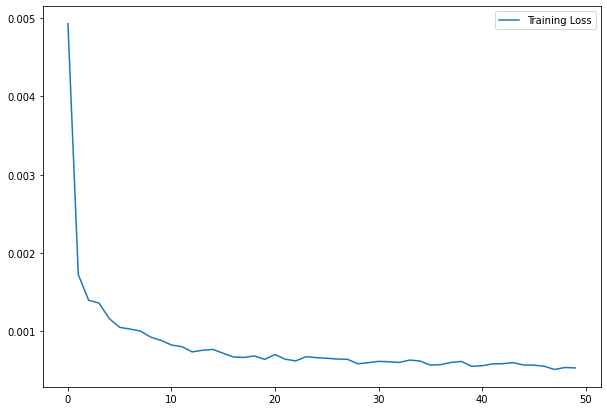

In [ ]:
train_loss = model_callback.history['loss']
epochs_list = list(range(50)) 
plt.figure(figsize=(10,7))
plt.plot(epochs_list,train_loss)
plt.legend(['Training Loss'])

In [ ]:
test_sz = np.int64(np.ceil((df.shape[0]-train_sz+n_steps)/n_steps)*n_steps) 
test_set = df.iloc[-test_sz:, 6:7].values
test_set_scaled = scaled.transform(test_set)

X_test = []
for i in range(60, test_sz):
    X_test.append(test_set_scaled[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

predicted_stock_price = model.predict(X_test)
predicted_stock_price = scaled.inverse_transform(predicted_stock_price)

<Figure size 432x288 with 0 Axes>

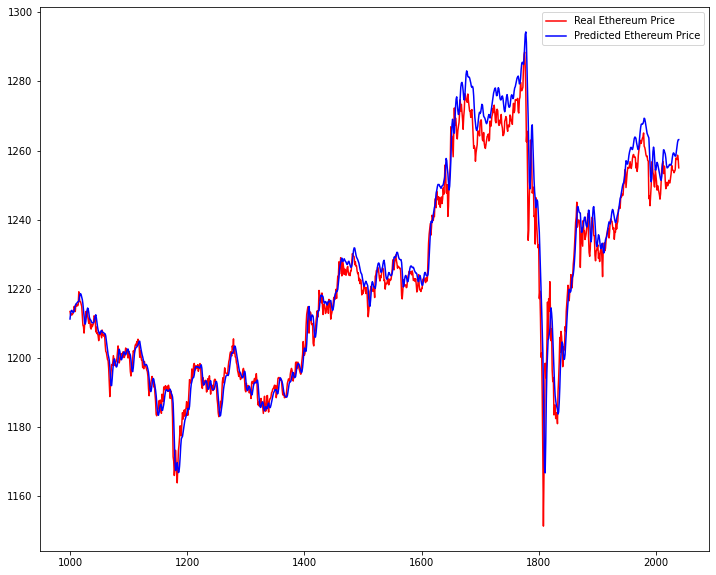

In [ ]:
# The results for this turned out really good, I think, because the sequence
# size was set to 60. Later on we use a sequence size of 30 and the results
# arent as good as they are right here.

time = []
for i in range(2040):
    time.append(i)
plt.figure()
fig,ax = plt.subplots(figsize=(12,10))
plt.plot(time[1000:], test_set[n_steps+1000:], color = 'red', label = 'Real Ethereum Price')
plt.plot(time[1000:], predicted_stock_price[1000:], color = 'blue', label = 'Predicted Ethereum Price')
plt.legend()

In [ ]:
# Reshaping Array for LSTM Function

# This will add the timesteps parameter to the data and we found this online
# THE DATA NEEDS TO BE TURNED INTO NUMPY ARRAYS
def reshape_array(x_data, y_data, time_step):
  X, y = list(), list()

  # .shape[0] returns the # of rows of the data
  for i in range(x_data.shape[0]):
    end_ix = i + time_step

    # End for loop after (# rows - time_step) is met
    if end_ix >= x_data.shape[0]:
      break

    # Capturing sequences with length (time_step)
    seq_X = x_data[i:end_ix]

    # Skips the first 30 entrys
    seq_y = y_data[end_ix]

    X.append(seq_X)
    y.append(seq_y)

  # Make final array
  X_array = np.array(X)
  y_array = np.array(y)

  return X_array, y_array

##################################################################
# Function will scale/normalize the data
def scaling_data(array_z):

  scale = MinMaxScaler(feature_range = (0,1))
  scaled_z = scale.fit_transform(array_z)

  # scaled_z is your scaled data
  # scale is needed to inverse_transform to the previous data
  return(scaled_z, scale)

##################################################################
# Reverse Scale
def reverse_scale(array_in, scale_param):
  return(scale_param.inverse_transform(array_in))

##################################################################
# Good Graphing Algorithm
def good_easy_graph(array_predict, array_actual):
  y_axis = len(array_predict)
  plt.plot(array_predict, color='blue', label= 'Predicted Cost')
  plt.plot(array_actual, color='red', label = 'Actual Cost')
  plt.legend()
  plt.show()


## **Giving RNN another Go**
### Second Test Run Because First One was a Fail I Followed a tutorial for some of this.

(10000, 13)


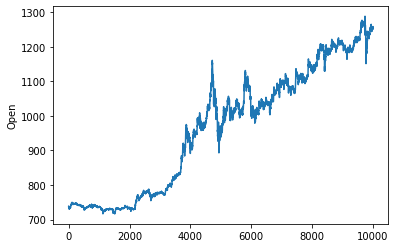

In [ ]:
print(df.shape)
df.head()

# Visualize Feature
sns.lineplot(x=df.index, y='Open', data=df)

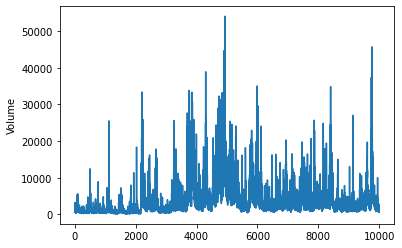

In [ ]:
# Visualize Feature
sns.lineplot(x=df.index, y='Volume', data=df)

In [ ]:
# Change dataframe to online include data that is in use
df = df[['Count', 'Volume', 'Open']]

# Make the test/train split with 90 percent being train data
train_size = int(len(df) * 0.9)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]

##############################################################
###################### Scale the values ######################
##############################################################

# Normally we would not scale the volume and count individually but
# we had to do that to be able to illustrate performing RNN without
# accurate previous data that is needed for RNN to successfully work

#features = ['Count', 'Volume']

#features_transformer = MinMaxScaler()
price_transformer = MinMaxScaler()
count_transformer = MinMaxScaler()
vol_transformer = MinMaxScaler()

# Scale the data to the train data. Not the test data. Increases test case performance
#features_transformer = features_transformer.fit(train[features].to_numpy())
price_transformer = price_transformer.fit(train[['Open']])
count_transformer = count_transformer.fit(train[['Count']])
vol_transformer = vol_transformer.fit(train[['Volume']])

# Scale all of the train data
#train.loc[:, features] = features_transformer.transform(train[features].to_numpy())
train['Open'] = price_transformer.transform(train[['Open']])
train['Count'] = count_transformer.transform(train[['Count']])
train['Volume'] = vol_transformer.transform(train[['Volume']])


# Scale all of the test data
#test.loc[:, features] = features_transformer.transform(test[features].to_numpy())
test['Open'] = price_transformer.transform(test[['Open']])
test['Count'] = count_transformer.transform(test[['Count']])
test['Volume'] = vol_transformer.transform(test[['Volume']])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [ ]:
##############################################################
# Turn the data into a sequence of data so that LSTM works####
def create_sequence(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i: (i + time_steps)].to_numpy()
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)



time_step = 30 # 30 minutes

# Turn the data into arrays
X_train, y_train = create_sequence(train, train.Open, time_step)
X_test, y_test = create_sequence(test, test.Open, time_step)

#############################################################
# Only need seperate y_train_count/vol and y_test_count/vol##
# so that I can predict their future values. This is needed##
# to illustrate the price with predicted previous values.

# Turn the data into arrays: with output(y) being Count
X_train, y_train_count = create_sequence(train, train.Count, time_step)
X_test, y_test_count = create_sequence(test, test.Count, time_step)

# Turn the data into arrays: with output(y) being Volume
X_train, y_train_vol = create_sequence(train, train.Volume, time_step)
X_test, y_test_vol = create_sequence(test, test.Volume, time_step)

# Visualize
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(df.head)

(8970, 30, 3) (8970,)
(970, 30, 3) (970,)
<bound method NDFrame.head of          Count    Volume      Open
0     0.067295  0.035712  0.042035
1     0.022911  0.010885  0.045014
2     0.017704  0.012522  0.043070
3     0.021274  0.011132  0.042604
4     0.046318  0.019120  0.041890
...        ...       ...       ...
9995  0.096752  0.044362  1.062341
9996  0.080982  0.030895  1.061954
9997  0.065956  0.018117  1.064418
9998  0.092090  0.049737  1.062537
9999  0.120704  0.040361  1.057247

[10000 rows x 3 columns]>


In [ ]:
########################################################
############ Test Models and Parameters ################
########################################################
# The focus of these tests will be on the open price
# of ethereum because that is what we are most interested
# in.

# Naming convention for models will be
# model_# LSTM layers_# units_trend. For the most part...
model_4_128_half = Sequential()

model_4_128_half.add(LSTM(units=128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences='True'))
# Dropout helps minimize overfitting by eliminating underperforming features
model_4_128_half.add(Dropout(rate=0.2))

model_4_128_half.add(LSTM(units=64, return_sequences='True'))
model_4_128_half.add(Dropout(rate=0.2))

model_4_128_half.add(LSTM(units=32, return_sequences='True'))
model_4_128_half.add(Dropout(rate=0.2))

model_4_128_half.add(LSTM(units=16))
model_4_128_half.add(Dropout(rate=0.2))

model_4_128_half.add(layers.Dense(units=1))

model_4_128_half.compile(loss='mean_squared_error', optimizer='adam')
###################################################################
###################################################################
model_4_128_cons = Sequential()

model_4_128_cons.add(LSTM(units=128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences='True'))
# Dropout helps minimize overfitting by eliminating underperforming features
model_4_128_cons.add(Dropout(rate=0.2))

model_4_128_cons.add(LSTM(units=128, return_sequences='True'))
model_4_128_cons.add(Dropout(rate=0.2))

model_4_128_cons.add(LSTM(units=128, return_sequences='True'))
model_4_128_cons.add(Dropout(rate=0.2))

model_4_128_cons.add(LSTM(units=128))
model_4_128_cons.add(Dropout(rate=0.2))

model_4_128_cons.add(layers.Dense(units=1))

model_4_128_cons.compile(loss='mean_squared_error', optimizer='adam')
###################################################################
###################################################################
model_4_128_r5 = Sequential()

model_4_128_r5.add(LSTM(units=128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences='True'))
# Dropout helps minimize overfitting by eliminating underperforming features
model_4_128_r5.add(Dropout(rate=0.5))

model_4_128_r5.add(LSTM(units=128, return_sequences='True'))
model_4_128_r5.add(Dropout(rate=0.5))

model_4_128_r5.add(LSTM(units=128, return_sequences='True'))
model_4_128_r5.add(Dropout(rate=0.5))

model_4_128_r5.add(LSTM(units=128))
model_4_128_r5.add(Dropout(rate=0.5))

model_4_128_r5.add(layers.Dense(units=1))

model_4_128_r5.compile(loss='mean_squared_error', optimizer='adam')
###################################################################
###################################################################
model_4_30 = Sequential()

model_4_30.add(LSTM(units=30, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences='True'))
# Dropout helps minimize overfitting by eliminating underperforming features
model_4_30.add(Dropout(rate=0.2))

model_4_30.add(LSTM(units=30, return_sequences='True'))
model_4_30.add(Dropout(rate=0.2))

model_4_30.add(LSTM(units=30, return_sequences='True'))
model_4_30.add(Dropout(rate=0.2))

model_4_30.add(LSTM(units=30))
model_4_30.add(Dropout(rate=0.2))

model_4_30.add(layers.Dense(units=1))

model_4_30.compile(loss='mean_squared_error', optimizer='adam')
###################################################################
###################################################################
model_1_30 = Sequential()

model_1_30.add(LSTM(units=30, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences='True'))
# Dropout helps minimize overfitting by eliminating underperforming features
model_1_30.add(Dropout(rate=0.2))

model_1_30.add(layers.Dense(units=1))

model_1_30.compile(loss='mean_squared_error', optimizer='adam')
###################################################################
###################################################################
model_8_30 = Sequential()

model_8_30.add(LSTM(units=30, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences='True'))
# Dropout helps minimize overfitting by eliminating underperforming features
model_8_30.add(Dropout(rate=0.2))

model_8_30.add(LSTM(units=30, return_sequences='True'))
model_8_30.add(Dropout(rate=0.2))

model_8_30.add(LSTM(units=30, return_sequences='True'))
model_8_30.add(Dropout(rate=0.2))

model_8_30.add(LSTM(units=30, return_sequences='True'))
model_8_30.add(Dropout(rate=0.2))

model_8_30.add(LSTM(units=30, return_sequences='True'))
model_8_30.add(Dropout(rate=0.2))

model_8_30.add(LSTM(units=30, return_sequences='True'))
model_8_30.add(Dropout(rate=0.2))

model_8_30.add(LSTM(units=30, return_sequences='True'))
model_8_30.add(Dropout(rate=0.2))

model_8_30.add(LSTM(units=30))
model_8_30.add(Dropout(rate=0.2))

model_8_30.add(layers.Dense(units=1))

model_8_30.compile(loss='mean_squared_error', optimizer='adam')
###################################################################
###################################################################
model_8_30_false = Sequential()

model_8_30_false.add(LSTM(units=30, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences='False'))
# Dropout helps minimize overfitting by eliminating underperforming features
model_8_30_false.add(Dropout(rate=0.2))

model_8_30_false.add(LSTM(units=30, return_sequences='False'))
model_8_30_false.add(Dropout(rate=0.2))

model_8_30_false.add(LSTM(units=30, return_sequences='False'))
model_8_30_false.add(Dropout(rate=0.2))

model_8_30_false.add(LSTM(units=30, return_sequences='False'))
model_8_30_false.add(Dropout(rate=0.2))

model_8_30_false.add(LSTM(units=30, return_sequences='False'))
model_8_30_false.add(Dropout(rate=0.2))

model_8_30_false.add(LSTM(units=30, return_sequences='False'))
model_8_30_false.add(Dropout(rate=0.2))

model_8_30_false.add(LSTM(units=30, return_sequences='False'))
model_8_30_false.add(Dropout(rate=0.2))

model_8_30_false.add(LSTM(units=30))
model_8_30_false.add(Dropout(rate=0.2))

model_8_30_false.add(layers.Dense(units=1))

model_8_30_false.compile(loss='mean_squared_error', optimizer='adam')


In [ ]:
# Fit model zero trained with Open as the output
history10 = model_4_128_half.fit(X_train, y_train,epochs=10,batch_size=32,validation_split=0.1,shuffle=False)

# Fit model one trained with Open as the output
history11 = model_4_128_cons.fit(X_train, y_train,epochs=10,batch_size=32,validation_split=0.1,shuffle=False)

# Fit model one trained with Open as the output
history12 = model_4_128_r5.fit(X_train, y_train,epochs=10,batch_size=32,validation_split=0.1,shuffle=False)

# Fit model one trained with Open as the output
history13 = model_4_30.fit(X_train, y_train,epochs=10,batch_size=32,validation_split=0.1,shuffle=False)

# Fit model one trained with Open as the output
history14 = model_1_30.fit(X_train, y_train,epochs=10,batch_size=32,validation_split=0.1,shuffle=False)

# Fit model one trained with Open as the output
history15 = model_8_30.fit(X_train, y_train,epochs=10,batch_size=32,validation_split=0.1,shuffle=False)

# Fit model one trained with Open as the output
history16 = model_8_30_false.fit(X_train, y_train,epochs=10,batch_size=32,validation_split=0.1,shuffle=False)

Epoch 1/10
253/253 [==============================] - 18s 44ms/step - loss: 0.0062 - val_loss: 0.0145
Epoch 2/10
253/253 [==============================] - 9s 36ms/step - loss: 0.0181 - val_loss: 0.0101
Epoch 3/10
253/253 [==============================] - 9s 36ms/step - loss: 0.0215 - val_loss: 0.0145
Epoch 4/10
253/253 [==============================] - 9s 36ms/step - loss: 0.0236 - val_loss: 0.0131
Epoch 5/10
253/253 [==============================] - 9s 37ms/step - loss: 0.0315 - val_loss: 0.0191
Epoch 6/10
253/253 [==============================] - 9s 36ms/step - loss: 0.0238 - val_loss: 0.0113
Epoch 7/10
253/253 [==============================] - 9s 36ms/step - loss: 0.0103 - val_loss: 0.0156
Epoch 8/10
253/253 [==============================] - 9s 36ms/step - loss: 0.0169 - val_loss: 0.0147
Epoch 9/10
253/253 [==============================] - 9s 36ms/step - loss: 0.0425 - val_loss: 0.0162
Epoch 10/10
253/253 [==============================] - 9s 36ms/step - loss: 0.0628 - val_l

(0.0, 0.03)

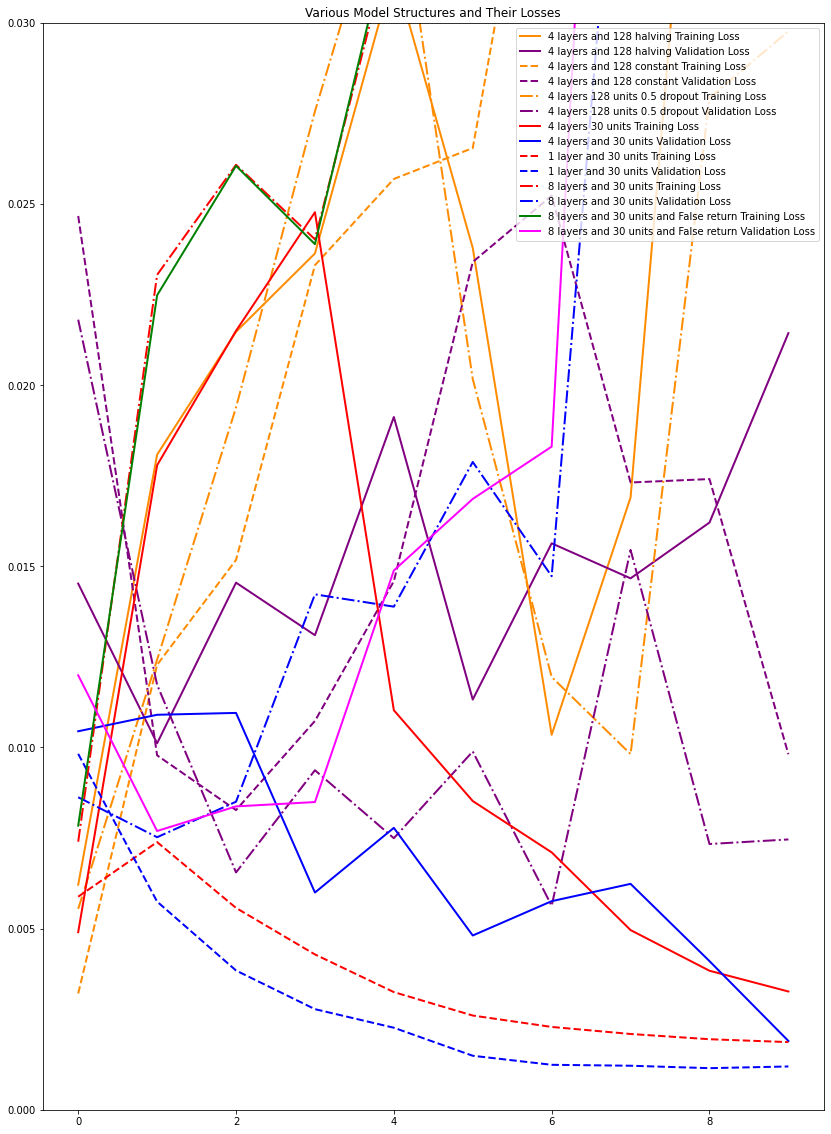

In [ ]:
plt.figure(figsize=(14,20))
# View the Training/Validation Loss for Model zero
plt.plot(history10.history['loss'], label='4 layers and 128 halving Training Loss', color='darkorange', linewidth = 2)
plt.plot(history10.history['val_loss'], label='4 layers and 128 halving Validation Loss', color='purple', linewidth = 2)
plt.legend()

# View the Training/Validation Loss for Model One
plt.plot(history11.history['loss'], label='4 layers and 128 constant Training Loss', linestyle = 'dashed', color='darkorange', linewidth = 2)
plt.plot(history11.history['val_loss'], label='4 layers and 128 constant Validation Loss', linestyle = 'dashed', color='purple', linewidth = 2)
plt.legend()

# View the Training/Validation Loss for Model Two
plt.plot(history12.history['loss'], label='4 layers 128 units 0.5 dropout Training Loss', linestyle = 'dashdot', color='darkorange', linewidth = 2)
plt.plot(history12.history['val_loss'], label='4 layers 128 units 0.5 dropout Validation Loss', linestyle = 'dashdot', color='purple', linewidth = 2)
plt.legend()

# View the Training/Validation Loss for Model zero
plt.plot(history13.history['loss'], label='4 layers 30 units Training Loss', color='red', linewidth = 2)
plt.plot(history13.history['val_loss'], label='4 layers and 30 units Validation Loss', color='blue', linewidth = 2)
plt.legend()

# View the Training/Validation Loss for Model One
plt.plot(history14.history['loss'], label='1 layer and 30 units Training Loss', linestyle = 'dashed', color='red', linewidth = 2)
plt.plot(history14.history['val_loss'], label='1 layer and 30 units Validation Loss', linestyle = 'dashed', color='blue', linewidth = 2)
plt.legend()

# View the Training/Validation Loss for Model Two
plt.plot(history15.history['loss'], label='8 layers and 30 units Training Loss', linestyle = 'dashdot', color='red', linewidth = 2)
plt.plot(history15.history['val_loss'], label='8 layers and 30 units Validation Loss', linestyle = 'dashdot', color='blue', linewidth = 2)
plt.legend()

# View the Training/Validation Loss for Model Two
plt.plot(history16.history['loss'], label='8 layers and 30 units and False return Training Loss', color='green', linewidth = 2)
plt.plot(history16.history['val_loss'], label='8 layers and 30 units and False return Validation Loss', color='magenta', linewidth = 2)
plt.legend()
plt.title("Various Model Structures and Their Losses")
plt.ylim(0,0.03)

In [ ]:
########################################################
############ Test Models and Parameters ################
########################################################
# Interestingly it appears that simplicity wins in this
# case. This makes since considering that the data isn't
# vary complex.
# The results show the following were best: lower number
# of layers, return set to true, and a higher dropout
# probability. We will test some of these attributes again
# with a lower layer size.

model_1_30 = Sequential()

model_1_30.add(LSTM(units=30, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences='True'))
# Dropout helps minimize overfitting by eliminating underperforming features
model_1_30.add(Dropout(rate=0.2))

model_1_30.add(layers.Dense(units=1))

model_1_30.compile(loss='mean_squared_error', optimizer='adam')
###################################################################
###################################################################
model_1_30_relu = Sequential()

model_1_30_relu.add(LSTM(units=30, input_shape=(X_train.shape[1], X_train.shape[2]), activation = 'relu',  return_sequences='True'))
# Dropout helps minimize overfitting by eliminating underperforming features
model_1_30_relu.add(Dropout(rate=0.2))

model_1_30_relu.add(layers.Dense(units=1))

model_1_30_relu.compile(loss='mean_squared_error', optimizer='adam')
###################################################################
###################################################################
model_1_30_ada = Sequential()

model_1_30_ada.add(LSTM(units=30, input_shape=(X_train.shape[1], X_train.shape[2]),  return_sequences='True'))
# Dropout helps minimize overfitting by eliminating underperforming features
model_1_30_ada.add(Dropout(rate=0.2))

model_1_30_ada.add(layers.Dense(units=1))

model_1_30_ada.compile(loss='mean_squared_error', optimizer='adadelta')
###################################################################
###################################################################
model_1_30_r5 = Sequential()

model_1_30_r5.add(LSTM(units=30, input_shape=(X_train.shape[1], X_train.shape[2]),  return_sequences='True'))
# Dropout helps minimize overfitting by eliminating underperforming features
model_1_30_r5.add(Dropout(rate=0.5))

model_1_30_r5.add(layers.Dense(units=1))

model_1_30_r5.compile(loss='mean_squared_error', optimizer='adam')
###################################################################
###################################################################
model_1_30_false = Sequential()

model_1_30_false.add(LSTM(units=30, input_shape=(X_train.shape[1], X_train.shape[2]),  return_sequences='False'))
# Dropout helps minimize overfitting by eliminating underperforming features
model_1_30_false.add(Dropout(rate=0.2))

model_1_30_false.add(layers.Dense(units=1))

model_1_30_false.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
# Fit model zero trained with Open as the output
history20 = model_1_30.fit(X_train, y_train,epochs=10,batch_size=32,validation_split=0.1,shuffle=False)

# Fit model one trained with Open as the output
history21 = model_1_30_relu.fit(X_train, y_train,epochs=10,batch_size=32,validation_split=0.1,shuffle=False)

# Fit model one trained with Open as the output
history22 = model_1_30_ada.fit(X_train, y_train,epochs=10,batch_size=32,validation_split=0.1,shuffle=False)

# Fit model one trained with Open as the output
history23 = model_1_30_r5.fit(X_train, y_train,epochs=10,batch_size=32,validation_split=0.1,shuffle=False)

# Fit model one trained with Open as the output
history24 = model_1_30_false.fit(X_train, y_train,epochs=10,batch_size=32,validation_split=0.1,shuffle=False)

# Fit model one trained with Open as the output
history25 = model_1_30.fit(X_train, y_train,epochs=10,batch_size=64,validation_split=0.1,shuffle=False)

# Fit model one trained with Open as the output
history26 = model_1_30.fit(X_train, y_train,epochs=10,batch_size=16,validation_split=0.1,shuffle=False)

Epoch 1/10
253/253 [==============================] - 3s 11ms/step - loss: 0.0134 - val_loss: 0.0106
Epoch 2/10
253/253 [==============================] - 3s 10ms/step - loss: 0.0161 - val_loss: 0.0077
Epoch 3/10
253/253 [==============================] - 3s 11ms/step - loss: 0.0087 - val_loss: 0.0039
Epoch 4/10
253/253 [==============================] - 3s 11ms/step - loss: 0.0037 - val_loss: 0.0024
Epoch 5/10
253/253 [==============================] - 3s 10ms/step - loss: 0.0025 - val_loss: 0.0017
Epoch 6/10
253/253 [==============================] - 3s 11ms/step - loss: 0.0023 - val_loss: 0.0015
Epoch 7/10
253/253 [==============================] - 3s 11ms/step - loss: 0.0021 - val_loss: 0.0015
Epoch 8/10
253/253 [==============================] - 3s 11ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 9/10
253/253 [==============================] - 3s 10ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 10/10
253/253 [==============================] - 3s 11ms/step - loss: 0.0018 - val_lo

(0.0, 0.01)

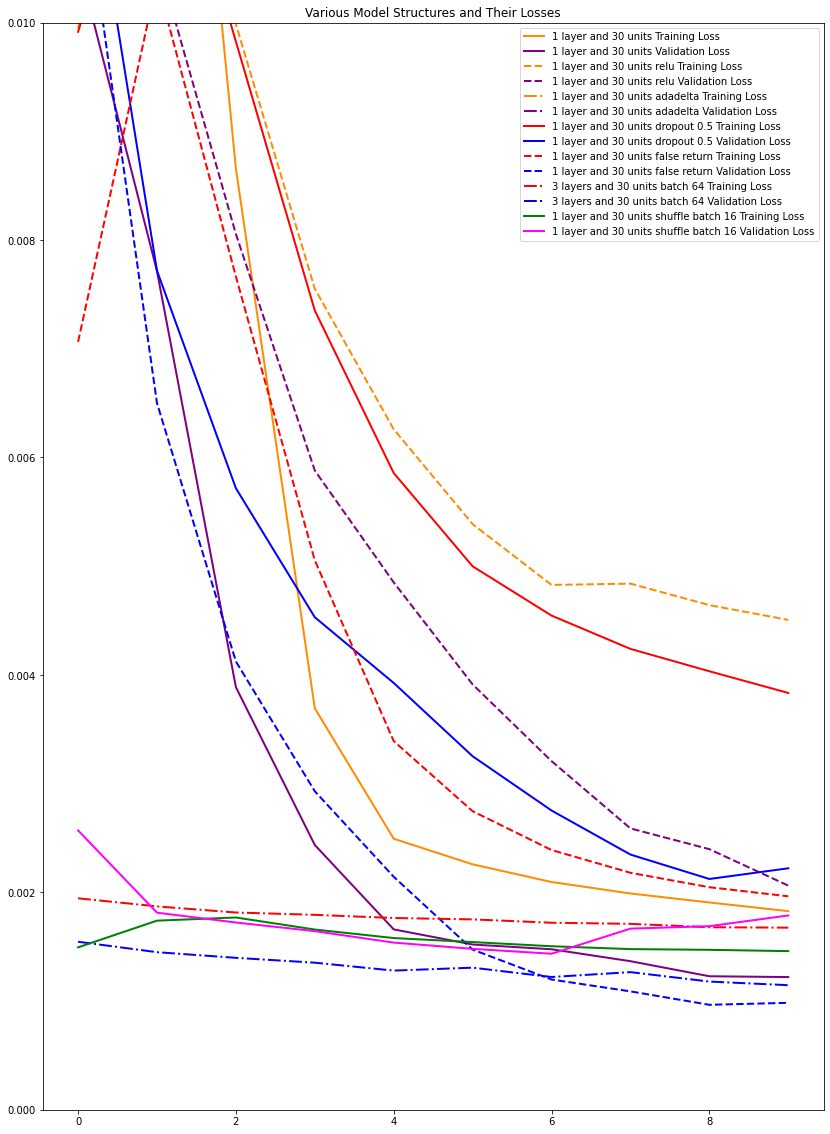

In [ ]:
plt.figure(figsize=(14,20))
# View the Training/Validation Loss for Model zero
plt.plot(history20.history['loss'], label='1 layer and 30 units Training Loss', color='darkorange', linewidth = 2)
plt.plot(history20.history['val_loss'], label='1 layer and 30 units Validation Loss', color='purple', linewidth = 2)
plt.legend()

# View the Training/Validation Loss for Model One
plt.plot(history21.history['loss'], label='1 layer and 30 units relu Training Loss', linestyle = 'dashed', color='darkorange', linewidth = 2)
plt.plot(history21.history['val_loss'], label='1 layer and 30 units relu Validation Loss', linestyle = 'dashed', color='purple', linewidth = 2)
plt.legend()

# View the Training/Validation Loss for Model Two
plt.plot(history22.history['loss'], label='1 layer and 30 units adadelta Training Loss', linestyle = 'dashdot', color='darkorange', linewidth = 2)
plt.plot(history22.history['val_loss'], label='1 layer and 30 units adadelta Validation Loss', linestyle = 'dashdot', color='purple', linewidth = 2)
plt.legend()

# View the Training/Validation Loss for Model zero
plt.plot(history23.history['loss'], label='1 layer and 30 units dropout 0.5 Training Loss', color='red', linewidth = 2)
plt.plot(history23.history['val_loss'], label='1 layer and 30 units dropout 0.5 Validation Loss', color='blue', linewidth = 2)
plt.legend()

# View the Training/Validation Loss for Model One
plt.plot(history24.history['loss'], label='1 layer and 30 units false return Training Loss', linestyle = 'dashed', color='red', linewidth = 2)
plt.plot(history24.history['val_loss'], label='1 layer and 30 units false return Validation Loss', linestyle = 'dashed', color='blue', linewidth = 2)
plt.legend()

# View the Training/Validation Loss for Model Two
plt.plot(history25.history['loss'], label='3 layers and 30 units batch 64 Training Loss', linestyle = 'dashdot', color='red', linewidth = 2)
plt.plot(history25.history['val_loss'], label='3 layers and 30 units batch 64 Validation Loss', linestyle = 'dashdot', color='blue', linewidth = 2)
plt.legend()

# View the Training/Validation Loss for Model Two
plt.plot(history26.history['loss'], label='1 layer and 30 units shuffle batch 16 Training Loss', color='green', linewidth = 2)
plt.plot(history26.history['val_loss'], label='1 layer and 30 units shuffle batch 16 Validation Loss', color='magenta', linewidth = 2)
plt.legend()
plt.title("Various Model Structures and Their Losses")
plt.ylim(0,0.01)

In [ ]:
# Define the Model
model = Sequential()

# Add a Long short-term memory layer
model.add(LSTM(units=30,input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences = 'True'))

# Add dropout layer to penalize more complex models
model.add(layers.Dropout(rate=0.2))

# One because we are guessing one output
model.add(layers.Dense(units=1))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

#############################################################
# These models only used to predict the count and volume
# seperately

# Define 2 more models
# Define the Model Count as Output
model1 = Sequential()
model1.add(
    # This is bidirectional meaning that it uses input from the past and future
    # Although when dealing with the price of ethereum we will only have data from the
    # past, I wanted to see how bidirectional performed
    layers.Bidirectional(
        layers.LSTM(
            units=30,
            input_shape=(X_train.shape[1], X_train.shape[2])
        )
    )
)

# Add dropout layer to penalize more complex models
model1.add(layers.Dropout(rate=0.2))

# One because we are guessing one output
model1.add(layers.Dense(units=1))

# Compile the model
model1.compile(loss='mean_squared_error', optimizer='adam')

model1.build(input_shape= (1, 30, 3))

# Define model2

# Define the Model Volume as Output
model2 = Sequential()
model2.add(LSTM(units=30, input_shape=(X_train.shape[1], X_train.shape[2])))

# Add dropout layer to penalize more complex models
model2.add(layers.Dropout(rate=0.2))

# One because we are guessing one output
model2.add(layers.Dense(units=1))

# Compile the model
model2.compile(loss='mean_squared_error', optimizer='adam')

#model2.summary()

In [ ]:
model.summary()
model1.summary()
model2.summary()

Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_65 (LSTM)              (None, 30, 30)            4080      
                                                                 
 dropout_61 (Dropout)        (None, 30, 30)            0         
                                                                 
 lstm_66 (LSTM)              (None, 30, 30)            7320      
                                                                 
 dropout_62 (Dropout)        (None, 30, 30)            0         
                                                                 
 lstm_67 (LSTM)              (None, 30, 30)            7320      
                                                                 
 dropout_63 (Dropout)        (None, 30, 30)            0         
                                                                 
 lstm_68 (LSTM)              (None, 30)              

In [ ]:
# Fit model zero trained with Open as the output
history = model.fit(X_train, y_train,epochs=30,batch_size=32,validation_split=0.1,shuffle=False)

# Fit model one trained with Count as the output
history1 = model1.fit(X_train, y_train_count,epochs=30,batch_size=32,validation_split=0.1,shuffle=False)

# Fit model two trained with Volume as the output
history2 = model2.fit(X_train, y_train_vol,epochs=30,batch_size=32,validation_split=0.1,shuffle=False)

Epoch 1/30
253/253 [==============================] - 6s 13ms/step - loss: 0.0066 - val_loss: 0.0106
Epoch 2/30
253/253 [==============================] - 3s 11ms/step - loss: 0.0087 - val_loss: 0.0059
Epoch 3/30
253/253 [==============================] - 3s 11ms/step - loss: 0.0068 - val_loss: 0.0041
Epoch 4/30
253/253 [==============================] - 3s 10ms/step - loss: 0.0045 - val_loss: 0.0031
Epoch 5/30
253/253 [==============================] - 3s 11ms/step - loss: 0.0033 - val_loss: 0.0022
Epoch 6/30
253/253 [==============================] - 3s 10ms/step - loss: 0.0027 - val_loss: 0.0017
Epoch 7/30
253/253 [==============================] - 3s 11ms/step - loss: 0.0024 - val_loss: 0.0014
Epoch 8/30
253/253 [==============================] - 3s 11ms/step - loss: 0.0022 - val_loss: 0.0013
Epoch 9/30
253/253 [==============================] - 3s 11ms/step - loss: 0.0020 - val_loss: 9.9568e-04
Epoch 10/30
253/253 [==============================] - 3s 11ms/step - loss: 0.0019 - va

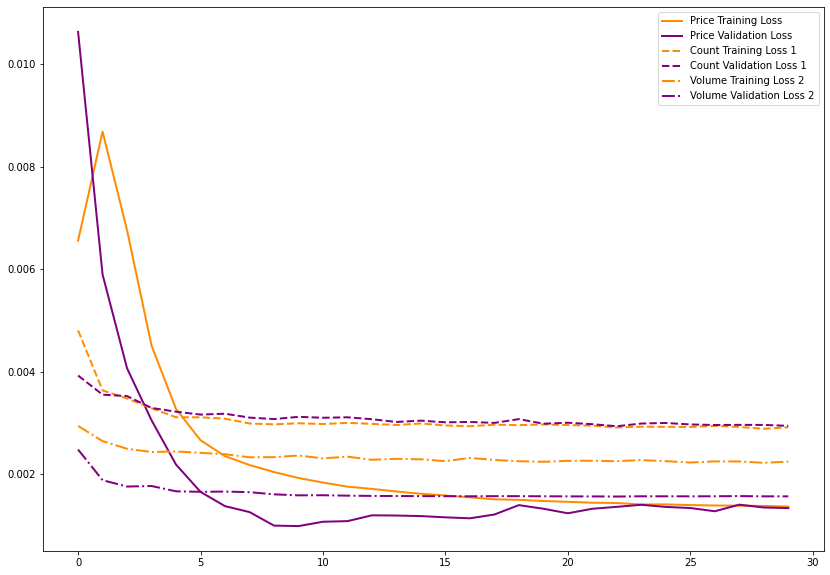

In [ ]:
plt.figure(figsize=(14,10))
# View the Training/Validation Loss for Model zero
plt.plot(history.history['loss'], label='Price Training Loss', color='darkorange', linewidth = 2)
plt.plot(history.history['val_loss'], label='Price Validation Loss', color='purple', linewidth = 2)
plt.legend()

# View the Training/Validation Loss for Model One
plt.plot(history1.history['loss'], label='Count Training Loss 1', linestyle = 'dashed', color='darkorange', linewidth = 2)
plt.plot(history1.history['val_loss'], label='Count Validation Loss 1', linestyle = 'dashed', color='purple', linewidth = 2)
plt.legend()

# View the Training/Validation Loss for Model Two
plt.plot(history2.history['loss'], label='Volume Training Loss 2', linestyle = 'dashdot', color='darkorange', linewidth = 2)
plt.plot(history2.history['val_loss'], label='Volume Validation Loss 2', linestyle = 'dashdot', color='purple', linewidth = 2)
plt.legend()

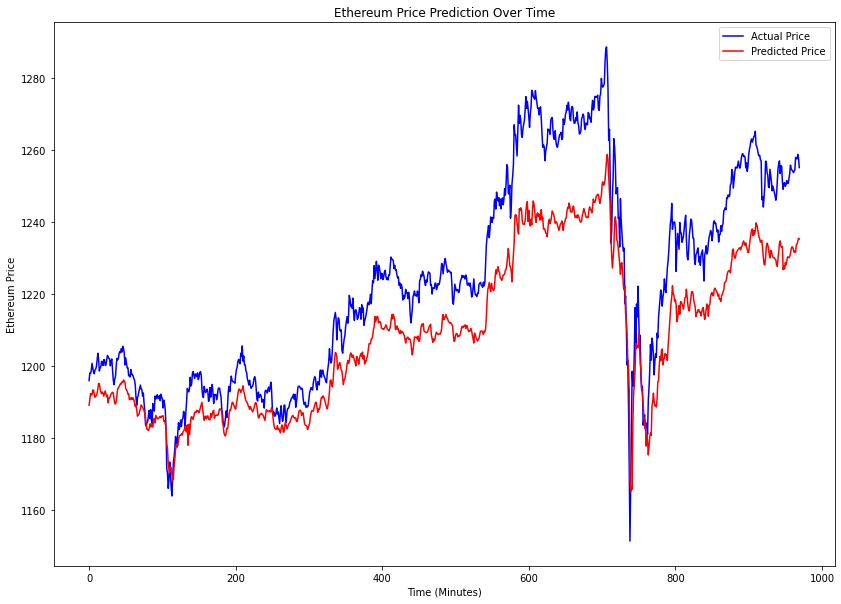

In [ ]:
# See how the model does
y_pred = model.predict(X_test)
y_pred_count = model1.predict(X_test)
y_pred_vol = model2.predict(X_test)

# Inverse the results. Unscale if you will
y_train_inv = price_transformer.inverse_transform(y_train.reshape(1,-1))
y_test_inv = price_transformer.inverse_transform(y_test.reshape(1,-1))
y_pred_inv = price_transformer.inverse_transform(y_pred)

y_train_count_inv = count_transformer.inverse_transform(y_train.reshape(1,-1))
y_test_count_inv = count_transformer.inverse_transform(y_test_count.reshape(1,-1))
y_pred_count_inv = count_transformer.inverse_transform(y_pred_count)

y_train_inv = vol_transformer.inverse_transform(y_train.reshape(1,-1))
y_test_vol_inv = vol_transformer.inverse_transform(y_test_vol.reshape(1,-1))
y_pred_vol_inv = vol_transformer.inverse_transform(y_pred_vol)


# Plot the results
plt.figure(figsize=(14,10))
plt.plot(y_test_inv.flatten() , label='Actual Price', color='blue')
plt.plot(y_pred_inv.flatten(), label='Predicted Price', color='red')
plt.title('Ethereum Price Prediction Over Time')
plt.xlabel('Time (Minutes)')
plt.ylabel('Ethereum Price')
plt.legend()

# From these graphs, one can see that the volume and count are highly correlated
# As one would think

(970, 1)
(970, 30, 3)


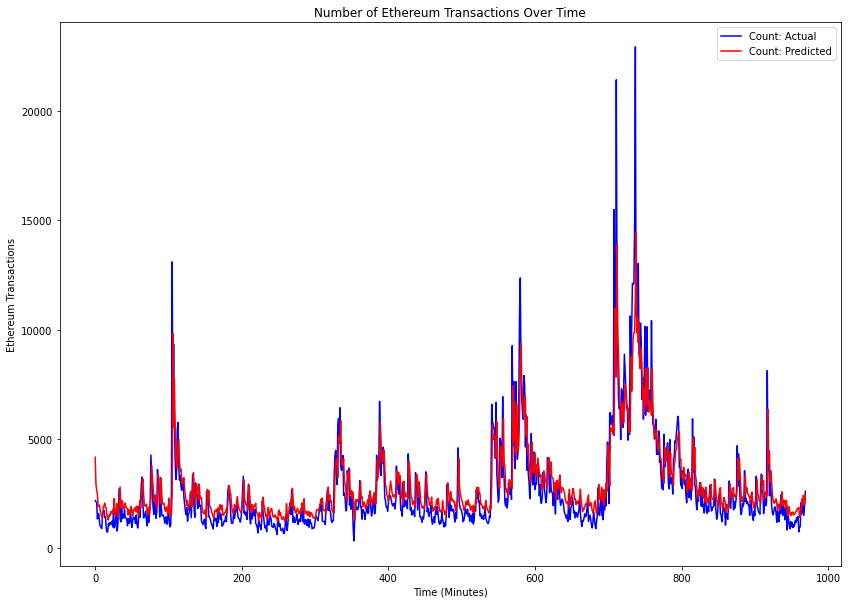

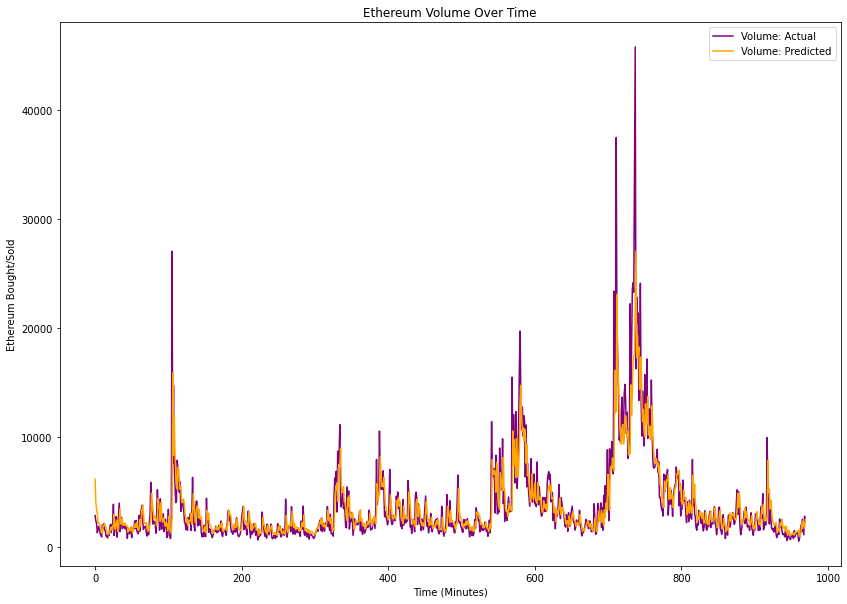

In [ ]:
# Plot results relating to the count
plt.figure(figsize=(14,10))
plt.plot(y_test_count_inv.flatten() , label='Count: Actual', color='blue')
plt.plot(y_pred_count_inv.flatten(), label='Count: Predicted', color='red')
plt.title('Number of Ethereum Transactions Over Time')
plt.xlabel('Time (Minutes)')
plt.ylabel('Ethereum Transactions')
plt.legend()
print(y_pred.shape)
print(X_test.shape)

# Plot the results relating to the volume
plt.figure(figsize=(14,10))
plt.plot(y_test_vol_inv.flatten() , label='Volume: Actual', color='purple')
plt.plot(y_pred_vol_inv.flatten(), label='Volume: Predicted', color='orange')
plt.title('Ethereum Volume Over Time')
plt.xlabel('Time (Minutes)')
plt.ylabel('Ethereum Bought/Sold')
plt.legend()

In [ ]:
###################################################
# Calculate model without having 30 days of correct data

y_pred2_inv = np.zeros(y_pred.shape)
y_pred2_count_inv = np.zeros(y_pred_count.shape)
y_pred2_vol_inv = np.zeros(y_pred_vol.shape)


j = 0
new_data = 0

for i in range(time_step, 1000): #time_step is = 30
    
    if i < 400:
        same_data = X_test[i-time_step:i, 0]
    else:
        temp1 = np.expand_dims(X_test[i-time_step:399, 0], axis=1)

        temp2 = count_transformer.transform(y_pred2_count_inv[j-(time_step-temp1.shape[0]):j])
        
        temp3 = vol_transformer.transform(y_pred2_vol_inv[j-(time_step-temp1.shape[0]):j])
        
        temp4 = price_transformer.transform(y_pred2_inv[j-(time_step-temp1.shape[0]):j])
        
        new_data_count = np.append(temp1[:,0,0],temp2[:,0],axis=0)
        new_data_vol = np.append(temp1[:,0,1],temp3[:,0],axis=0)
        new_data_open = np.append(temp1[:,0,2],temp4[:,0],axis=0)
        
        new_data = np.column_stack((new_data_count, new_data_vol, new_data_open))
        
        same_data = 0
    
    data = same_data + new_data
    
    
    # Change data[1,30] to data[1,30,3]
    data = np.reshape(data, (1, data.shape[0], 3))
    
    # Push the data into the algorithm and store the result in y_pred
    y_pred2 = model.predict(data)
    y_pred2_count = model1.predict(data)
    y_pred2_vol = model2.predict(data)
    
    # Unscale if you will the output from the model (y_pred)
    y_pred2_inv[j] = price_transformer.inverse_transform(y_pred2)
    y_pred2_count_inv[j] = count_transformer.inverse_transform(y_pred2_count)
    y_pred2_vol_inv[j] = vol_transformer.inverse_transform(y_pred2_vol)
    
    j += 1

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature na

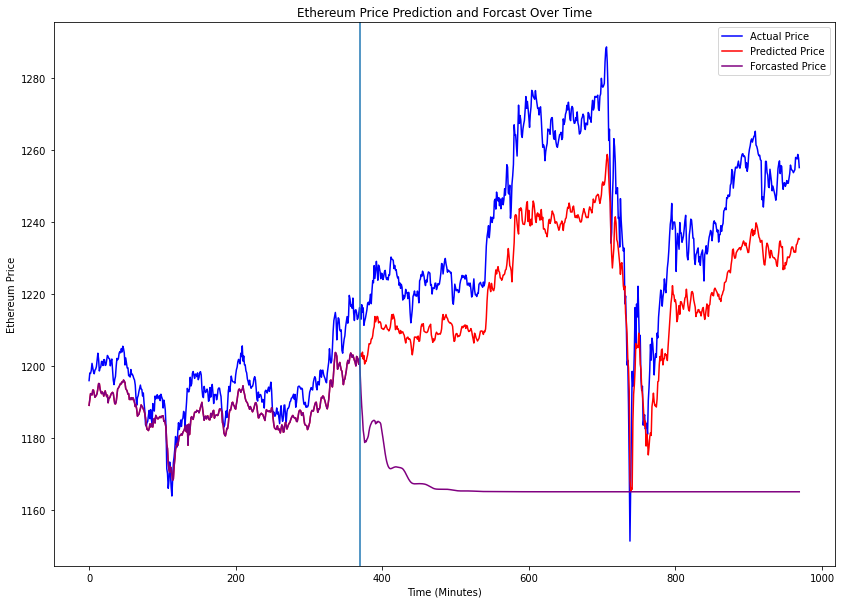

In [ ]:
# Plot the results
plt.figure(figsize=(14,10))
plt.plot(y_test_inv.flatten() , label='Actual Price', color='blue')
plt.plot(y_pred_inv.flatten(), label='Predicted Price', color='red')
plt.plot(y_pred2_inv.flatten(), label='Forcasted Price', color='purple')
plt.title('Ethereum Price Prediction and Forcast Over Time')
plt.xlabel('Time (Minutes)')
plt.ylabel('Ethereum Price')
plt.axvline(x=370)
#plt.xlim([360,380])
#plt.ylim([1100,1300])
plt.legend()

## Logistic Regression and Cross Validation

In [ ]:
#Cross Validation Inputs
x_cv_df = df[['Count','Volume']]
x_cv = x_cv_df.iloc[:,0:2].values
y_cv_df = df['Open']
y_cv = y_cv_df.iloc[:].values
print(x_cv, '\n')
print(y_cv, '\n')

lasso = linear_model.Lasso()
cv_results = cross_validate(lasso, x_cv,y_cv,cv=3)
sorted(cv_results)
scores = cross_validate(lasso, x_cv, y_cv, cv=3,
                        scoring=('r2', 'neg_mean_squared_error'),
                        return_train_score=True)
print(scores['test_neg_mean_squared_error'], '\n')

print(scores['train_r2'])

[[0.06729482 0.03571173]
 [0.02291098 0.01088493]
 [0.01770394 0.01252245]
 ...
 [0.06595586 0.01811722]
 [0.09209026 0.04973667]
 [0.12070419 0.04036133]] 

[0.04203468 0.04501436 0.04307038 ... 1.06441768 1.06253681 1.05724739] 

[-0.4070174  -0.02505672 -0.34832249] 

[0. 0. 0.]


RSS for multiple linear regression = 96.43920424413042
TSS for multiple linear regression = 123.19015195468786
R^2 for multiple linear regression = 0.2171516739454713
RSE for multiple linear regression = 0.31085763491105606


(0.0, 30.0)

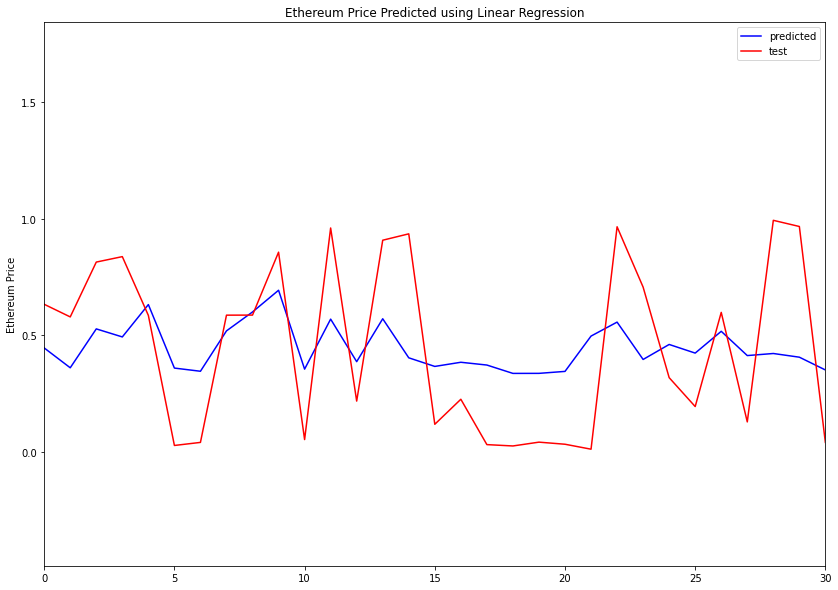

In [ ]:
#Splitting the Data 90% train 10% Test
train_x, test_x, train_y, test_y = train_test_split(x_cv, y_cv,train_size=9/10, random_state=None)
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(train_x,train_y)
predicted_y = reg.predict(test_x)

#Plotting the data
plt.figure(figsize=(14,10))
plt.plot(predicted_y,label = 'predicted',color='blue')
plt.plot(test_y, label = 'test', color = 'red')
plt.title('Ethereum Price Predicted using Linear Regression')
plt.ylabel('Ethereum Price')
plt.legend()

#Computing RSS
RSS_multi = 0
for i in range(0, len(test_y)):
    RSS_multi = RSS_multi + (test_y[i] - predicted_y[i])**2

print('RSS for multiple linear regression =', RSS_multi)

# Computing TSS
mu_y = test_y.mean()
TSS_multi = 0
for i in range(0, len(test_y)):
    TSS_multi = TSS_multi + (test_y[i] - mu_y)**2

print('TSS for multiple linear regression =', TSS_multi)

# Cosmputing R^2

R2 = 1 - (RSS_multi / TSS_multi)
print('R^2 for multiple linear regression =', R2)

# Computing RSE for multiple linear regression

RSE_multi = np.sqrt((1/(len(test_y)-2))*RSS_multi)
print('RSE for multiple linear regression =', RSE_multi)



plt.xlim(0,30)